In [1]:
#importo i moduli necessari, i più importanti dei quali sono quelli forniti dalla libreria qiskit
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [2]:
# costruzione dell'operatore unario U per l'algoritmo di stima della fase
# questo algoritmo è adattato per il caso di studio scelto: N=15
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        #creo un circuito con 4 bit
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control() #trasformo il circuito in porta logica controllata
    return c_U

In [3]:
# definizione algoritmo dell'inversa della Trasformata di Fourier Quantistica
def qft_dagger(n):
    qc = QuantumCircuit(n) #creo il circuito quantistico
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1) #inverto l'ordine dei qbit perchè creiamo l'inversa della trasformata
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j) #applico ad ogni qubit delle rotazioni controllate
        qc.h(j) #applico hadamard ai qbit
    qc.name = "QFT†"
    return qc

In [4]:
# algoritmo di stima della fase
def qpe_amod15(a):
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # inizializzazione dei qbit nello stato |+>
    qc.x(3+n_count) # registro ausiliario nello stato |1>
    for q in range(n_count): # Applicazione dell'operatore U
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    # applicazione dell'inversa della Trasformata di Fourier Quantistica
    qc.append(qft_dagger(n_count), range(n_count))
    # applicazione della misura sul circuito
    qc.measure(range(n_count), range(n_count))
    # operazioni per la crazione dell'istogramma
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    counts = result.get_counts()
    # stampa delle misure delle fasi
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    plot_histogram(counts)
    return phase, qc


In [5]:
# andrò a fattorizzare il numero 15 prodotto dei numeri primi 3 e 5
N = 15
# a è un numero scelto random che sia minore di 15 esclouso 1
# per replicabilità degli outpu fisso arbitrariamente a=7
a = 7
# Inizializzazione del circuito quantistico
# questo numero è dato dai 4 qbit necessari per codificare il valore decimanle 15
# e da 4 qubit necessari per l'algoritmo di stima della fase
n_count = 8
#inizialmente non ho nessun fattore
factor_found = False
attempt = 0

qc = QuantumCircuit(4+n_count, n_count)

# ripeto l'algoritmo finchè non trovo un fattore primo valido
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase, qc = qpe_amod15(a) 
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
#i comandi che seguono servono per la stampa del disegno deil circuito
#qc.draw(fold=-1)


Attempt 1:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


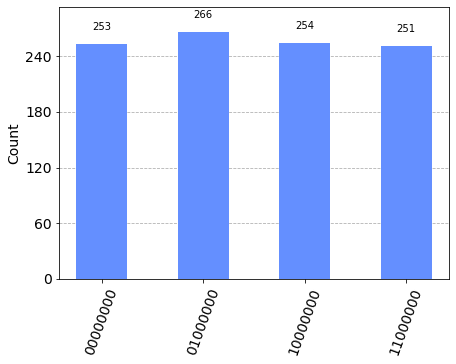

In [6]:
plot_histogram(counts)